# Libraries

In [42]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model

import os

import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np

import datetime

import pandas as pd

import seaborn as sns

import scipy as sp
from scipy import stats

import pickle

# Statics

In [43]:
MODEL_PATH = os.path.join(os.getcwd(), 'model', 'model.h5')

log_dir = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
LOG_PATH = os.path.join(os.getcwd(), 'logs', log_dir)

# User-defined functions

In [64]:
# plot correlation matrix using logistic regression
def categorical_matrix_display(df, columns):
    dim = len(columns)
    array = np.zeros((dim, dim))          

    for i, name1 in enumerate(columns):
        
        for j, name2 in enumerate(columns):
            logit = LogisticRegression()
            logit.fit(df[name1].values.reshape(-1, 1), df[name2])
            score = logit.score(df[name1].values.reshape(-1, 1), df[name2])
            array[i, j] = score

    arrayFrame = pd.DataFrame(data=array, columns=columns)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(arrayFrame, 
                annot=True, 
                ax=ax, 
                yticklabels=columns, 
                vmin=0, 
                vmax=1)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.tight_layout()
    plt.show()


# function to calculate Cramer's V value
def cramers_V(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


# plot correaltion matrix using the cramer's V values
def cramersVMatrix(df, col):
    len_cat = len(col)
    array  = np.zeros((len_cat, len_cat))

    for i, name1 in enumerate(col):
        
        for j, name2 in enumerate(col):
            cross_tab = pd.crosstab(df[name1], df[name2]).to_numpy()
            value = cramers_V(cross_tab)
            array[i, j] = value

    array_frame = pd.DataFrame(data=array, columns=col)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    sns.heatmap(array_frame, 
                annot=True, 
                ax=ax, 
                yticklabels=col, 
                vmin=0, 
                vmax=1)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.tight_layout()
    plt.show()

# Data loading

In [45]:
DATA_PATH = os.path.join(os.getcwd(), 'data', 'Train.csv')
df = pd.read_csv(DATA_PATH)
df

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,id_27290,58.0,admin.,married,secondary,no,567.0,yes,no,cellular,2,feb,99.0,2.0,265.0,3,other,0
31643,id_20428,51.0,management,married,tertiary,no,1072.0,no,no,unknown,20,jun,31.0,7.0,NaN,0,unknown,0
31644,id_44679,41.0,unemployed,married,primary,no,242.0,yes,no,unknown,23,may,89.0,2.0,NaN,0,unknown,0
31645,id_4841,48.0,services,married,secondary,no,2699.0,no,no,cellular,11,aug,216.0,6.0,NaN,0,unknown,0


# Data wrangling

## drop 'id' column

In [46]:
df = df.drop(columns='id')
df

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0
1,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0
2,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0
3,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0
4,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,58.0,admin.,married,secondary,no,567.0,yes,no,cellular,2,feb,99.0,2.0,265.0,3,other,0
31643,51.0,management,married,tertiary,no,1072.0,no,no,unknown,20,jun,31.0,7.0,NaN,0,unknown,0
31644,41.0,unemployed,married,primary,no,242.0,yes,no,unknown,23,may,89.0,2.0,NaN,0,unknown,0
31645,48.0,services,married,secondary,no,2699.0,no,no,cellular,11,aug,216.0,6.0,NaN,0,unknown,0


## basic info

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_age                      31028 non-null  float64
 1   job_type                          31647 non-null  object 
 2   marital                           31497 non-null  object 
 3   education                         31647 non-null  object 
 4   default                           31647 non-null  object 
 5   balance                           31248 non-null  float64
 6   housing_loan                      31647 non-null  object 
 7   personal_loan                     31498 non-null  object 
 8   communication_type                31647 non-null  object 
 9   day_of_month                      31647 non-null  int64  
 10  month                             31647 non-null  object 
 11  last_contact_duration             31336 non-null  float64
 12  num_

In [48]:
df.isnull().sum()

customer_age                          619
job_type                                0
marital                               150
education                               0
default                                 0
balance                               399
housing_loan                            0
personal_loan                         149
communication_type                      0
day_of_month                            0
month                                   0
last_contact_duration                 311
num_contacts_in_campaign              112
days_since_prev_campaign_contact    25831
num_contacts_prev_campaign              0
prev_campaign_outcome                   0
term_deposit_subscribed                 0
dtype: int64

## drop 'days_since_prev_campaign_contact' column due to too many NAs

In [49]:
df = df.drop(columns='days_since_prev_campaign_contact')
df

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,0,unknown,0
1,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,1,other,0
2,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,0,unknown,0
3,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,0,unknown,0
4,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,58.0,admin.,married,secondary,no,567.0,yes,no,cellular,2,feb,99.0,2.0,3,other,0
31643,51.0,management,married,tertiary,no,1072.0,no,no,unknown,20,jun,31.0,7.0,0,unknown,0
31644,41.0,unemployed,married,primary,no,242.0,yes,no,unknown,23,may,89.0,2.0,0,unknown,0
31645,48.0,services,married,secondary,no,2699.0,no,no,cellular,11,aug,216.0,6.0,0,unknown,0


In [50]:
df.isnull().sum()

customer_age                  619
job_type                        0
marital                       150
education                       0
default                         0
balance                       399
housing_loan                    0
personal_loan                 149
communication_type              0
day_of_month                    0
month                           0
last_contact_duration         311
num_contacts_in_campaign      112
num_contacts_prev_campaign      0
prev_campaign_outcome           0
term_deposit_subscribed         0
dtype: int64

## numerical features

In [51]:
num_cols = ['customer_age', 'balance', 'day_of_month', 'last_contact_duration', 'num_contacts_in_campaign', 'num_contacts_prev_campaign']
df[num_cols]

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign
0,28.0,285.0,26,303.0,4.0,0
1,34.0,934.0,18,143.0,2.0,1
2,46.0,656.0,5,101.0,4.0,0
3,34.0,2.0,20,127.0,3.0,0
4,41.0,1352.0,13,49.0,2.0,0
...,...,...,...,...,...,...
31642,58.0,567.0,2,99.0,2.0,3
31643,51.0,1072.0,20,31.0,7.0,0
31644,41.0,242.0,23,89.0,2.0,0
31645,48.0,2699.0,11,216.0,6.0,0


c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:229: UserWarning: When passing multiple axes, layout keyword is ignored.
  warnings.warn(


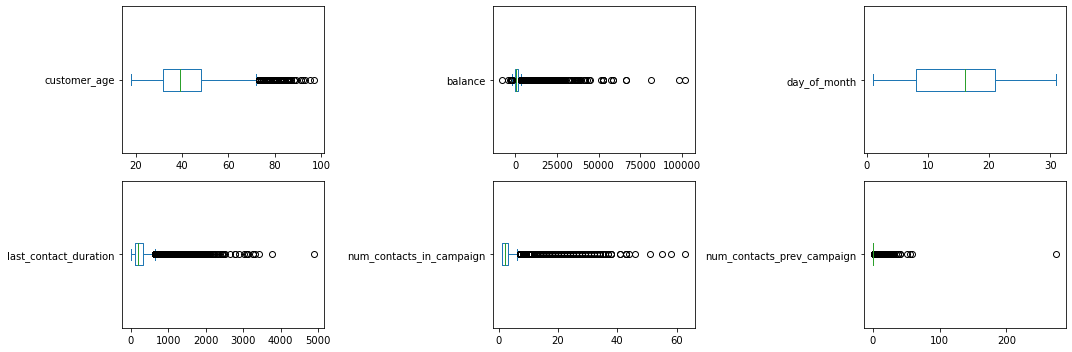

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))

df[num_cols].plot.box(layout=(2, 3), 
                      subplots=True, 
                      ax=ax, 
                      vert=False, 
                      sharex=False)

plt.tight_layout()
plt.show()

### because there are outliers, we fill the NAs with the medians

In [53]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df.isnull().sum()

customer_age                    0
job_type                        0
marital                       150
education                       0
default                         0
balance                         0
housing_loan                    0
personal_loan                 149
communication_type              0
day_of_month                    0
month                           0
last_contact_duration           0
num_contacts_in_campaign        0
num_contacts_prev_campaign      0
prev_campaign_outcome           0
term_deposit_subscribed         0
dtype: int64

## fillna for categorical columns

In [54]:
cat_cols = list(df.drop(columns=num_cols).columns)

df[cat_cols] = df[cat_cols].fillna(method='ffill', axis=0)

df.isnull().sum()

customer_age                  0
job_type                      0
marital                       0
education                     0
default                       0
balance                       0
housing_loan                  0
personal_loan                 0
communication_type            0
day_of_month                  0
month                         0
last_contact_duration         0
num_contacts_in_campaign      0
num_contacts_prev_campaign    0
prev_campaign_outcome         0
term_deposit_subscribed       0
dtype: int64

# Filter-out outliers

In [41]:
# for i, col in enumerate(num_cols):
#     q1 = np.quantile(df[col], 0.25)
#     q3 = np.quantile(df[col], 0.75)
#     iqr = q3 - q1
#     upper = q3 + 1.5*iqr
#     lower = q1 - 1.5*iqr
#     df = df.loc[(df[col]>lower) & (df[col]<upper)]

### we dont filter-out outliers for this dataset/case because it would left us with 0 data points

### plot correlation matrix for numerical features

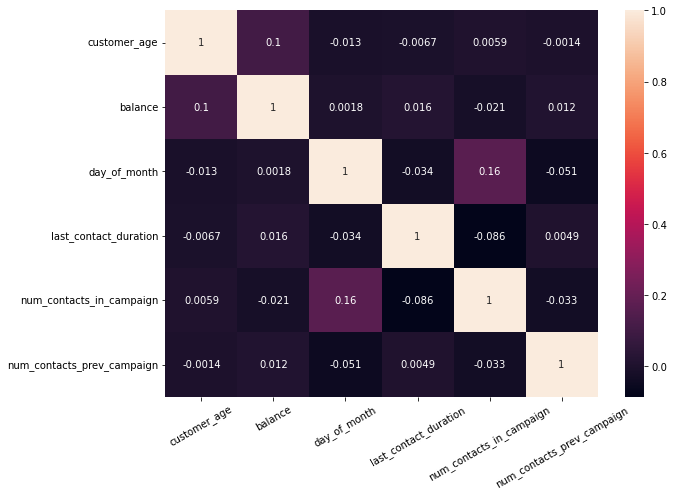

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

sns.heatmap(df[num_cols].corr(), 
            annot=True, 
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.tight_layout()
plt.show()

### countplots for categorical features

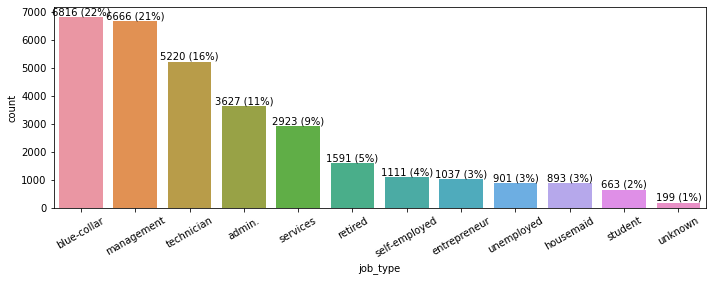

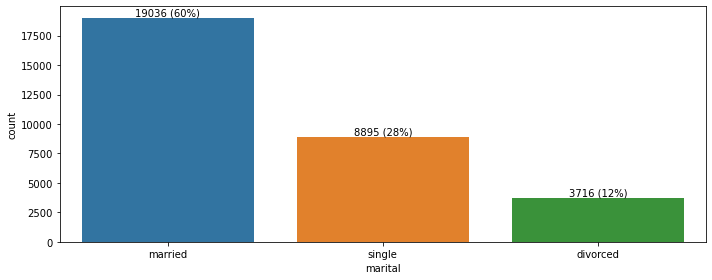

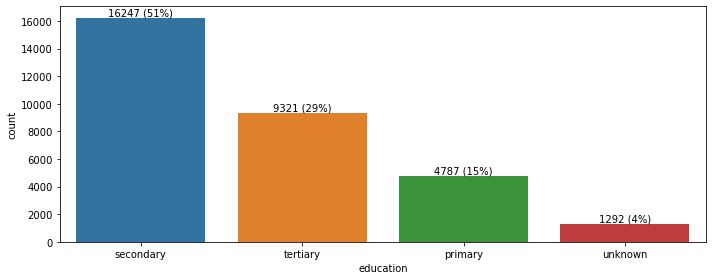

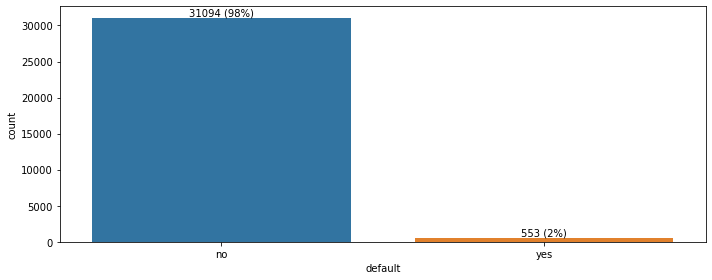

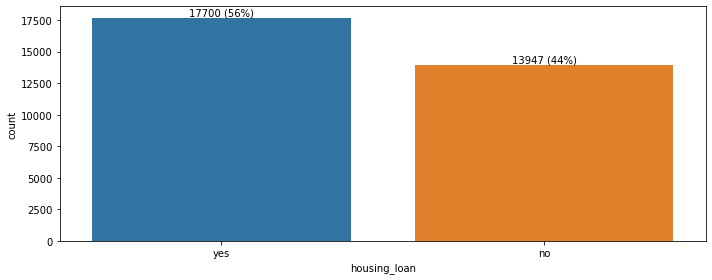

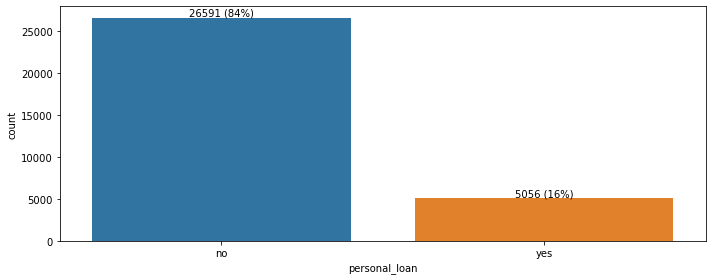

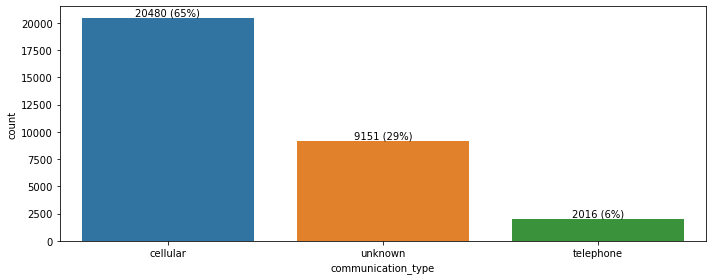

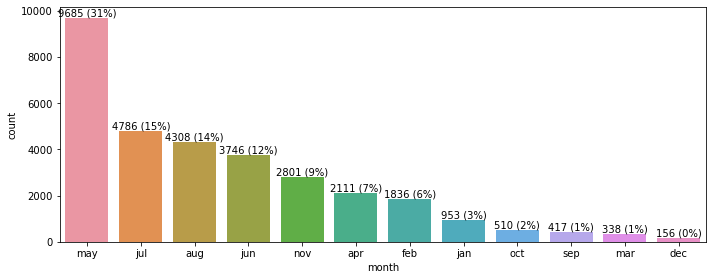

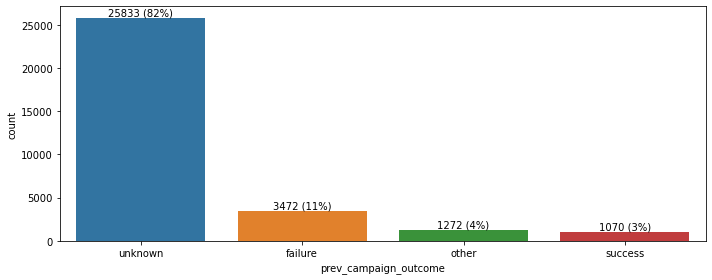

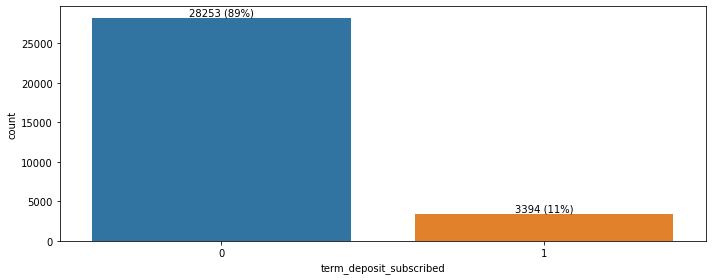

In [59]:
for i, col in enumerate(cat_cols):
    
    if col=='job_type':
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        ax = sns.countplot(x=df[col], 
                           order=df[col].value_counts(ascending=False).index)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
        abs_values = df[col].value_counts(ascending=False)
        rel_values = df[col].value_counts(ascending=False, normalize=True).values*100
        lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
        ax.bar_label(container=ax.containers[0], labels=lbls)

        plt.tight_layout()
        plt.show() 
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        ax = sns.countplot(x=df[col], 
                           order=df[col].value_counts(ascending=False).index)
        abs_values = df[col].value_counts(ascending=False)
        rel_values = df[col].value_counts(ascending=False, normalize=True).values*100
        lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
        ax.bar_label(container=ax.containers[0], labels=lbls)
        
        plt.tight_layout()
        plt.show()  

# Preprocessing

## encode all categorical features using Ordinal encoder

In [61]:
oe = OrdinalEncoder()
df[cat_cols[0: -1]] = oe.fit_transform(df[cat_cols[0: -1]])
df

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,28.0,4.0,2.0,2.0,0.0,285.0,1.0,0.0,2.0,26,6.0,303.0,4.0,0,3.0,0
1,34.0,1.0,1.0,1.0,0.0,934.0,0.0,1.0,0.0,18,9.0,143.0,2.0,1,1.0,0
2,46.0,9.0,1.0,1.0,0.0,656.0,0.0,0.0,0.0,5,3.0,101.0,4.0,0,3.0,0
3,34.0,7.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,20,8.0,127.0,3.0,0,3.0,0
4,41.0,1.0,1.0,0.0,0.0,1352.0,1.0,0.0,0.0,13,8.0,49.0,2.0,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,58.0,0.0,1.0,1.0,0.0,567.0,1.0,0.0,0.0,2,3.0,99.0,2.0,3,1.0,0
31643,51.0,4.0,1.0,2.0,0.0,1072.0,0.0,0.0,2.0,20,6.0,31.0,7.0,0,3.0,0
31644,41.0,10.0,1.0,0.0,0.0,242.0,1.0,0.0,2.0,23,8.0,89.0,2.0,0,3.0,0
31645,48.0,7.0,1.0,1.0,0.0,2699.0,0.0,0.0,0.0,11,1.0,216.0,6.0,0,3.0,0


## show the encoded categories for each features

In [62]:
oe.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single'], dtype=object),
 array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['cellular', 'telephone', 'unknown'], dtype=object),
 array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
        'nov', 'oct', 'sep'], dtype=object),
 array(['failure', 'other', 'success', 'unknown'], dtype=object)]

## save the ordinal encoder

In [283]:
OE_PATH = os.path.join(os.getcwd(), 'model', 'oe.pkl')

with open(OE_PATH, 'wb') as file:
    pickle.dump(oe, file)

## plot correlation matrix for categorical features using logistic regression

c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

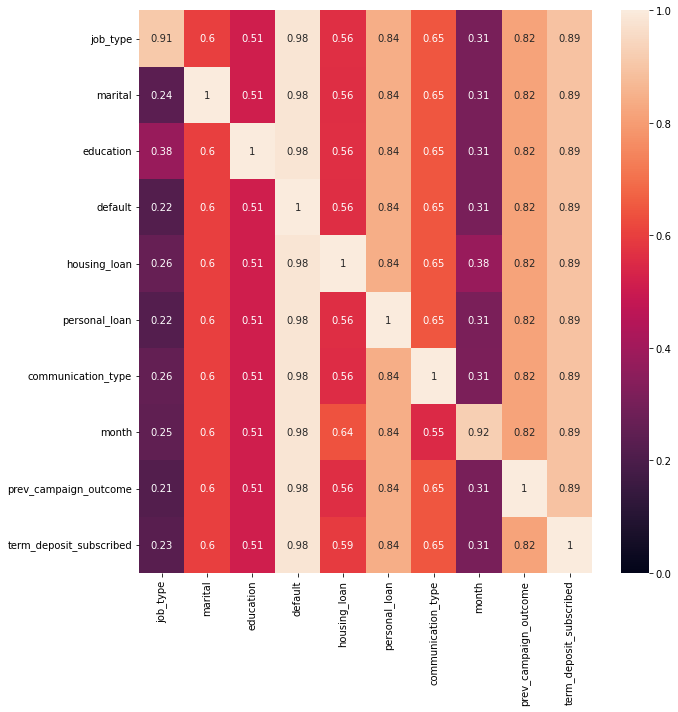

In [63]:
categorical_matrix_display(df, cat_cols)

## plot correlation matrix for categorical features using cramer's V values

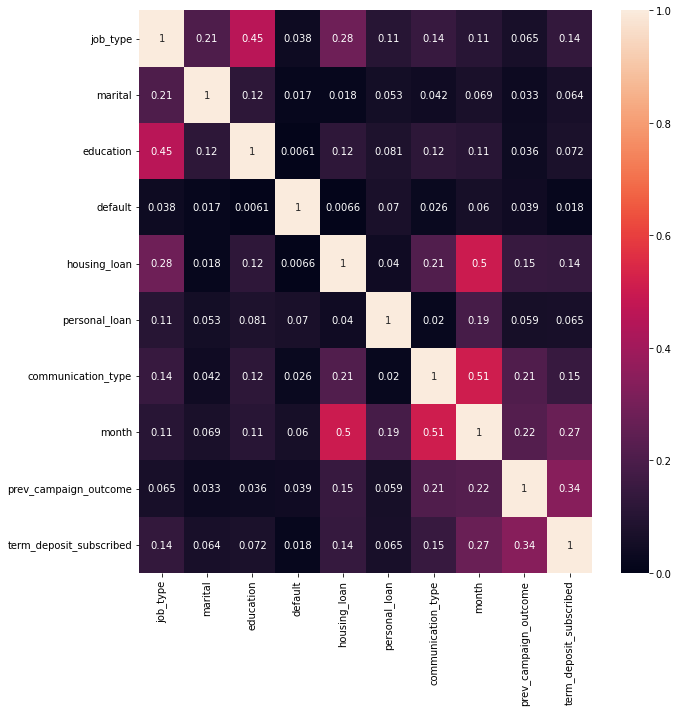

In [65]:
cramersVMatrix(df, cat_cols)

# Features and target separation

## create features

In [70]:
X = df.drop(columns='term_deposit_subscribed')
X

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome
0,28.0,4.0,2.0,2.0,0.0,285.0,1.0,0.0,2.0,26,6.0,303.0,4.0,0,3.0
1,34.0,1.0,1.0,1.0,0.0,934.0,0.0,1.0,0.0,18,9.0,143.0,2.0,1,1.0
2,46.0,9.0,1.0,1.0,0.0,656.0,0.0,0.0,0.0,5,3.0,101.0,4.0,0,3.0
3,34.0,7.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,20,8.0,127.0,3.0,0,3.0
4,41.0,1.0,1.0,0.0,0.0,1352.0,1.0,0.0,0.0,13,8.0,49.0,2.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,58.0,0.0,1.0,1.0,0.0,567.0,1.0,0.0,0.0,2,3.0,99.0,2.0,3,1.0
31643,51.0,4.0,1.0,2.0,0.0,1072.0,0.0,0.0,2.0,20,6.0,31.0,7.0,0,3.0
31644,41.0,10.0,1.0,0.0,0.0,242.0,1.0,0.0,2.0,23,8.0,89.0,2.0,0,3.0
31645,48.0,7.0,1.0,1.0,0.0,2699.0,0.0,0.0,0.0,11,1.0,216.0,6.0,0,3.0


## create target

In [72]:
y = df[['term_deposit_subscribed']]
y

,term_deposit_subscribed
0,0
1,0
2,0
3,0
4,0
...,...
31642,0
31643,0
31644,0
31645,0


## encode the target using OneHotEncoder

In [73]:
ohe = OneHotEncoder(sparse=False)

y_encoded = ohe.fit_transform(y)
y_encoded
# target_encoded = pd.DataFrame(ohe.fit_transform(np.expand_dims(df['term_deposit_subscribed'], -1)), 
#                               columns=['term_deposit_subscribed_no', 'term_deposit_subscribed_yes'])
# df = df.merge(target_encoded, left_index=True, right_index=True)
# df

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### the categories observed in the target

In [74]:
ohe.categories_

[array([0, 1], dtype=int64)]

### save the one hot encoder

In [ ]:
OHE_PATH = os.path.join(os.getcwd(), 'model', 'ohe.pkl')

with open(OHE_PATH, 'wb') as file:
    pickle.dump(ohe, file)

# Train-test splitting

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=140922)

In [82]:
X_train

,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,num_contacts_prev_campaign,prev_campaign_outcome
4731,33.0,4.0,2.0,2.0,0.0,-61.0,1.0,1.0,0.0,28,1.0,712.0,7.0,0,3.0
14123,33.0,4.0,0.0,2.0,0.0,470.0,0.0,0.0,2.0,23,8.0,225.0,4.0,0,3.0
10637,46.0,9.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,20,6.0,0.0,5.0,0,3.0
1638,36.0,0.0,1.0,1.0,0.0,168.0,0.0,1.0,2.0,20,6.0,109.0,1.0,0,3.0
21341,46.0,6.0,0.0,1.0,0.0,1963.0,1.0,0.0,0.0,4,3.0,76.0,2.0,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6915,35.0,4.0,1.0,2.0,0.0,904.0,1.0,0.0,0.0,7,8.0,136.0,1.0,2,0.0
12331,54.0,5.0,0.0,2.0,0.0,349.0,1.0,0.0,0.0,12,8.0,160.0,2.0,1,0.0
17454,43.0,4.0,2.0,1.0,0.0,1059.0,1.0,0.0,0.0,31,5.0,9.0,35.0,0,3.0
24939,65.0,5.0,1.0,3.0,0.0,1844.0,0.0,0.0,0.0,1,11.0,102.0,2.0,0,3.0


In [83]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# Deep learning

## create the layers

In [84]:
input_1 = Input(shape=(15,))

dense_0 = Dense(units=16, activation='relu', kernel_initializer='lecun_normal')(input_1)
dense_1 = Dense(units=32, activation='relu', kernel_initializer='lecun_normal')(dense_0)
dense_2 = Dense(units=64, activation='relu', kernel_initializer='lecun_normal')(dense_1)
dense_3 = Dense(units=128, activation='relu', kernel_initializer='lecun_normal')(dense_2)
dense_4 = Dense(units=128, activation='relu', kernel_initializer='lecun_normal')(dense_3)
dense_5 = Dense(units=64, activation='relu', kernel_initializer='lecun_normal')(dense_4)
dense_6 = Dense(units=32, activation='relu', kernel_initializer='lecun_normal')(dense_5)
dense_7 = Dense(units=16, activation='relu', kernel_initializer='lecun_normal')(dense_6)
dense_8 = Dense(units=8, activation='relu', kernel_initializer='lecun_normal')(dense_7)
dense_9 = Dense(units=4, activation='relu', kernel_initializer='lecun_normal')(dense_8)

output_1 = Dense(units=2, activation='softmax')(dense_9)

## create the Model object

In [85]:
model = Model(inputs=input_1, outputs=output_1)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

## plot model

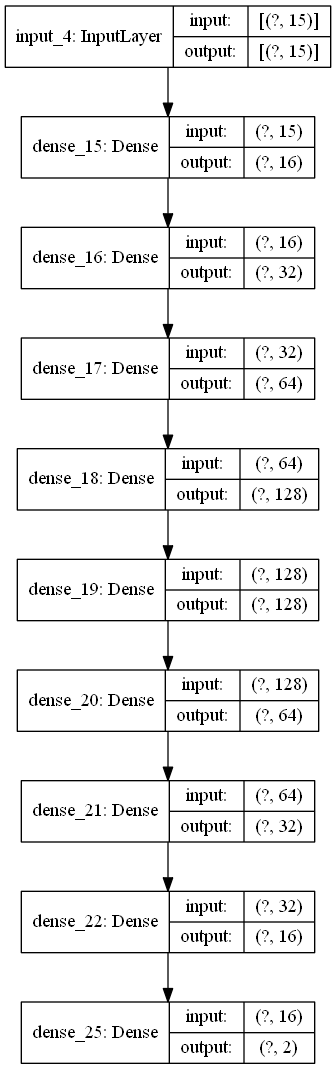

In [330]:
plot_model(model, show_shapes=True, show_layer_names=(True))

## compile the model

In [86]:
# compiling
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='acc')

## callbacks

In [87]:
early_stopping_callback = EarlyStopping(verbose=1)
tensorboard_callback = TensorBoard(log_dir=LOG_PATH)

## model fitting/training

In [89]:
model_hist = model.fit(X_train,
                       y_train,
                       batch_size=250,
                       epochs=100,
                       callbacks=[tensorboard_callback],
                       validation_data=(X_test, y_test))

Epoch 1/100
102/102 [==============================] - 0s 5ms/step - loss: 0.2678 - acc: 0.8963 - val_loss: 0.2522 - val_acc: 0.9024
Epoch 2/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2757 - acc: 0.8951 - val_loss: 0.2570 - val_acc: 0.9038
Epoch 3/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2702 - acc: 0.8950 - val_loss: 0.2711 - val_acc: 0.9039
Epoch 4/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2642 - acc: 0.8960 - val_loss: 0.2508 - val_acc: 0.9041
Epoch 5/100
102/102 [==============================] - 1s 5ms/step - loss: 0.2623 - acc: 0.8968 - val_loss: 0.2539 - val_acc: 0.9055
Epoch 6/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2630 - acc: 0.8954 - val_loss: 0.2496 - val_acc: 0.9039
Epoch 7/100
102/102 [==============================] - 0s 3ms/step - loss: 0.2623 - acc: 0.8942 - val_loss: 0.2475 - val_acc: 0.9032
Epoch 8/100
102/102 [==============================] - 0s 4ms/step - 

## evaluate on test set

In [90]:
model.evaluate(X_test, y_test)

198/198 [==============================] - 0s 2ms/step - loss: 0.2140 - acc: 0.9046


[0.21404889225959778, 0.9045813679695129]

## plot performance los/metrics against epochs

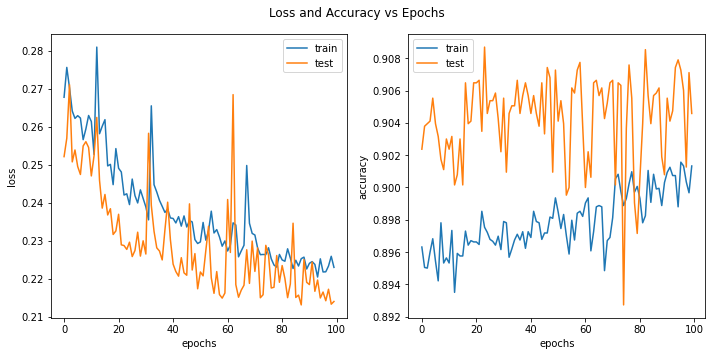

In [91]:
train_loss = model_hist.history['loss']
train_metric = model_hist.history['acc']
test_loss = model_hist.history['val_loss']
test_metric = model_hist.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle('Loss and Accuracy vs Epochs')

ax[0].plot(train_loss, label='train')
ax[0].plot(test_loss, label='test')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(train_metric, label='train')
ax[1].plot(test_metric, label='test')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

# Tensorboard launching

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

# Predictions and Metrics

## predictions

In [92]:
# predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# the true labels
y_true = ohe.inverse_transform(y_test)[:, 0]

y_true

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## classification report

In [93]:
report = classification_report(y_true, y_pred, target_names=['not subscribed', 'subscribed'])
print(report)

                precision    recall  f1-score   support

not subscribed       0.93      0.96      0.95      5688
    subscribed       0.54      0.38      0.44       642

      accuracy                           0.90      6330
     macro avg       0.74      0.67      0.70      6330
  weighted avg       0.89      0.90      0.90      6330



## confusion matrix

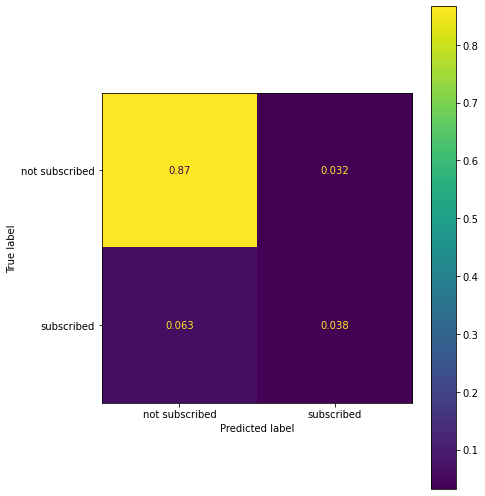

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ConfusionMatrixDisplay.from_predictions(y_true, 
                                        y_pred, 
                                        normalize='all', 
                                        ax=ax, 
                                        display_labels=['not subscribed', 'subscribed'])
plt.tight_layout()
plt.show()

# Save the trained model

In [ ]:
model.save(MODEL_PATH)